In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from liwc import Liwc
from statsmodels.discrete.discrete_model import Logit
from tqdm import tqdm

tqdm.pandas()

In [2]:
filepaths = yaml.load(open("/home/luiznery/locus/dissertation/config/filepaths.yaml"))

/tmp/ipykernel_485948/152710845.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  filepaths = yaml.load(open("/home/luiznery/locus/dissertation/config/filepaths.yaml"))


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
np.random.seed(1007)

#### Dataset

In [5]:
DATASET = 'twitter' # youtube | coraal-buckeye | twitter | interview
score = 'perspective_score'

BINS = 50

WH_VAL = -1
AA_VAL = 1

FILEPATH_KEY = None
if DATASET == 'youtube':
    FILEPATH_KEY = '05_youtube_features'
elif DATASET == 'coraal-buckeye':
    FILEPATH_KEY = '05_buckeye_corall_features'
elif DATASET == 'twitter':
    FILEPATH_KEY = '05_twitter_features'
else:
    raise Exception('Dataset does not exists')

df = pd.read_csv(filepaths[FILEPATH_KEY])
print(df.shape)
print(list(df.columns))

(500, 105)
['text', 'perspective_score', 'flair_score', 'textblob_score', 'vader_score', 'detoxify_original_score', 'detoxify_unbiased_score', 'detoxify_multilingual_score', 'has_swearing', 'file', 'group', 'race', 'clean_text', 'liwc_interrog', 'liwc_informal', 'liwc_netspeak', 'liwc_function', 'liwc_pronoun', 'liwc_ppron', 'liwc_you', 'liwc_social', 'liwc_male', 'liwc_adverb', 'liwc_verb', 'liwc_drives', 'liwc_reward', 'liwc_focuspast', 'liwc_prep', 'liwc_relativ', 'liwc_space', 'liwc_article', 'liwc_home', 'liwc_conj', 'liwc_cogproc', 'liwc_differ', 'liwc_i', 'liwc_auxverb', 'liwc_bio', 'liwc_ingest', 'liwc_adj', 'liwc_affect', 'liwc_negemo', 'liwc_anger', 'liwc_posemo', 'liwc_swear', 'liwc_focuspresent', 'liwc_time', 'liwc_negate', 'liwc_ipron', 'liwc_they', 'liwc_discrep', 'liwc_cause', 'liwc_compare', 'liwc_quant', 'liwc_achiev', 'liwc_work', 'liwc_affiliation', 'liwc_leisure', 'liwc_insight', 'liwc_tentat', 'liwc_certain', 'liwc_health', 'liwc_sad', 'liwc_death', 'liwc_anx', 'li

In [6]:
liwc_cols = [col for col in df.columns if 'liwc_' in col]
pos_cols = [col for col in df.columns if 'pos_' in col]
features = ['aae_terms_count'] + liwc_cols + pos_cols
print(len(features))

92


In [7]:
y_cols = [col for col in df.columns if '_score' in col]
print(len(y_cols))

7


In [8]:
extra_cols = list(set(list(df.columns)) - set(features) - set(y_cols))
print(len(extra_cols))

6


#### Null analysis

In [9]:
print('There feature colums with null values?', (df[features].isnull().sum()>0).any())
print('There y colums with null values?', (df[y_cols].isnull().sum()>0).any())

There feature colums with null values? False
There y colums with null values? False


#### Enconding on 'race' variable 

In [10]:
df.race.value_counts(dropna=False)

aa    250
wh    250
Name: race, dtype: int64

In [11]:
df['race'] = df['race'].apply(lambda x: 0 if x=='wh' else 1)

#### Normalizing

TODO: Normalizar por linha

In [12]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [13]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [14]:
df[features].describe()

,aae_terms_count,liwc_interrog,liwc_informal,liwc_netspeak,liwc_function,liwc_pronoun,liwc_ppron,liwc_you,liwc_social,liwc_male,...,pos_SCONJ,pos_PRON,pos_AUX,pos_PROPN,pos_SYM,pos_CCONJ,pos_PART,pos_NUM,pos_X,pos_SPACE
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,...,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,1.207923e-16,1.773026e-16,2.747802e-17,-2.737810e-16,5.662137e-17,9.910128e-17,9.370282e-17,-1.295630e-16,-1.303402e-16,1.660894e-16,...,-7.638334e-17,-1.835199e-16,4.080070e-16,2.491340e-16,-7.882583e-17,-9.325873e-18,9.769963e-17,-1.947331e-16,4.272138e-16,6.317169e-17
std,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,...,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00
min,-3.296171e-01,-4.271011e-01,-7.800118e-01,-5.945640e-01,-1.667283e+00,-1.321238e+00,-1.170885e+00,-4.845957e-01,-8.778057e-01,-3.439665e-01,...,-5.456805e-01,-1.223612e+00,-8.553466e-01,-6.223527e-01,-3.270930e-01,-5.111372e-01,-6.695775e-01,-3.618594e-01,-2.577498e-01,-1.479044e-01
25%,-3.296171e-01,-4.271011e-01,-7.800118e-01,-5.945640e-01,-7.420427e-01,-6.415887e-01,-3.416463e-01,-4.845957e-01,-8.778057e-01,-3.439665e-01,...,-5.456805e-01,-5.438277e-01,-8.553466e-01,-6.223527e-01,-3.270930e-01,-5.111372e-01,-6.695775e-01,-3.618594e-01,-2.577498e-01,-1.479044e-01
50%,-3.296171e-01,-4.271011e-01,9.640596e-02,-5.945640e-01,-1.252159e-01,3.806034e-02,-3.416463e-01,-4.845957e-01,-7.247937e-02,-3.439665e-01,...,-5.456805e-01,-2.039354e-01,1.605045e-01,-6.223527e-01,-3.270930e-01,-5.111372e-01,-6.695775e-01,-3.618594e-01,-2.577498e-01,-1.479044e-01
75%,-3.296171e-01,-4.271011e-01,9.640596e-02,5.146972e-01,4.916110e-01,7.177094e-01,4.875924e-01,-4.845957e-01,7.328470e-01,-3.439665e-01,...,-5.140469e-02,8.157416e-01,1.605045e-01,2.492898e-01,-3.270930e-01,-5.111372e-01,8.117886e-01,-3.618594e-01,-2.577498e-01,-1.479044e-01
max,4.902401e+00,6.316601e+00,5.354913e+00,7.170264e+00,4.500986e+00,4.115954e+00,3.804547e+00,5.498068e+00,6.370131e+00,6.822002e+00,...,5.385629e+00,3.534880e+00,5.239760e+00,5.479145e+00,5.035088e+00,6.539031e+00,5.255887e+00,6.177768e+00,1.085215e+01,1.290248e+01


#### Adding intercept

In [15]:
df['intercept'] = 1
features.append('intercept')
features.append('race')

#### Model

In [16]:
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split

In [17]:
df_train,df_test = train_test_split(df, stratify=df['race'])

In [18]:
model = Logit(df_train[score], df_train[features]).fit()
model

Optimization terminated successfully.
         Current function value: 0.319107
         Iterations 8


#### Predicting

In [19]:
df_test['pred_score'] = model.predict(df_test[features])
df_train['pred_score'] = model.predict(df_train[features])

#### Evaluating error

In [20]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

print('Train:')
print(mean_absolute_error(df_train[score],df_train['pred_score']))
print(median_absolute_error(df_train[score],df_train['pred_score']))

print()
print('Test:')
print(mean_absolute_error(df_test[score],df_test['pred_score']))
print(median_absolute_error(df_test[score],df_test['pred_score']))


Train:
0.08883425442187431
0.06502557870116141

Test:
0.10260096375390922
0.08134930223076406


<AxesSubplot:>

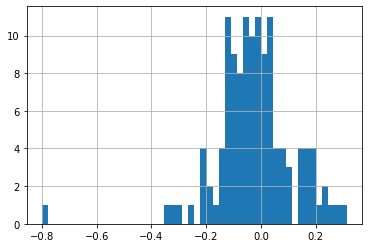

In [21]:
(df_test[score] - df_test['pred_score']).hist(bins=BINS)

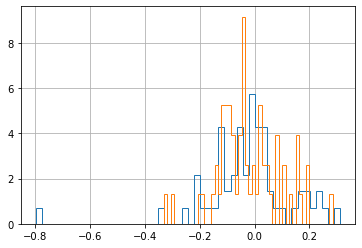

In [22]:
(df_test[df_test.race==0][score] - df_test[df_test.race==0]['pred_score']).hist(bins=BINS,density=True,histtype='step')
(df_test[df_test.race==1][score] - df_test[df_test.race==1]['pred_score']).hist(bins=BINS,density=True,histtype='step')
plt.show()

#### Evaluating Features

In [23]:
param_df = pd.DataFrame(list(zip(model.pvalues.index, model.pvalues.values, model.params.values)), columns=['col','pval','param'])
param_df = param_df.sort_values('param',key=lambda x: abs(x),ascending=False)
print(len(param_df))
print(len(param_df[param_df.pval<0.05]))
param_df[param_df.pval<0.05]

94
1


,col,pval,param
92,intercept,3.028833e-08,-1.432376


In [24]:
param_df.iloc[:30]

# Hipotese nula: parametro igual a zero -> rejeitar significa evidencia que a var é relevante pra classificação

,col,pval,param
92,intercept,3.028833e-08,-1.432376
29,liwc_negemo,8.979892e-01,0.722563
32,liwc_swear,5.944766e-02,0.675135
2,liwc_informal,4.277708e-01,0.526934
28,liwc_affect,9.511495e-01,-0.495762
3,liwc_netspeak,3.950481e-01,-0.398000
4,liwc_function,7.328605e-01,-0.375796
93,race,4.347860e-01,0.310861
16,liwc_relativ,8.430918e-01,-0.306577
70,liwc_sexual,1.927490e-01,0.284635


In [25]:
df.loc[df.race==1,features].mean().sort_values().iloc[-20:]


liwc_differ        0.026555
liwc_money         0.030355
liwc_friend        0.040825
liwc_power         0.049541
liwc_interrog      0.067437
liwc_negemo        0.074468
liwc_anx           0.075216
liwc_female        0.083311
liwc_shehe         0.090006
liwc_anger         0.092408
liwc_sexual        0.097282
liwc_body          0.104989
liwc_male          0.105101
aae_terms_count    0.120336
pos_PROPN          0.162126
liwc_swear         0.293616
liwc_netspeak      0.386023
liwc_informal      0.443467
intercept          1.000000
race               1.000000
dtype: float64

In [26]:
df.loc[df.race==0,features].mean().sort_values().iloc[-20:]

liwc_adverb          0.112428
liwc_achiev          0.122513
pos_DET              0.133313
liwc_leisure         0.140322
liwc_certain         0.144561
liwc_verb            0.145687
liwc_posemo          0.146455
liwc_focuspresent    0.149783
pos_ADP              0.150130
liwc_relativ         0.151592
liwc_cogproc         0.156617
pos_ADV              0.156857
pos_SYM              0.166228
liwc_prep            0.172699
liwc_article         0.174364
liwc_auxverb         0.179530
liwc_time            0.196385
pos_AUX              0.213329
liwc_function        0.217740
intercept            1.000000
dtype: float64

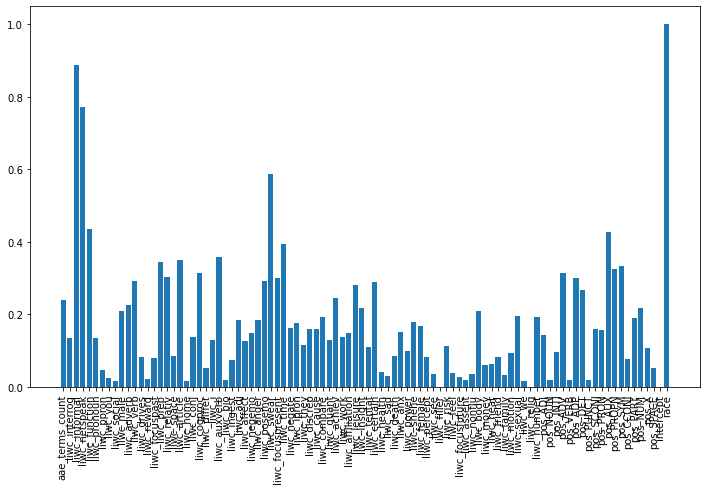

In [27]:
data = np.abs(
    df.loc[df.race==1,features].mean()
    - df.loc[df.race==0,features].mean()
)

plt.subplots(figsize=(12,7))
plt.bar(data.index, data.values)
plt.xticks(rotation=90)
plt.show()